# Data Challenge - Semester 6 Advanced AI - Steven Ly

## 📃 Context
The domain of this data challenge is the food and beverages industry. Specifically, it is about the cafeteria business Den Besterd in Tilburg. This local cafetaria sells typical Dutch fries and snacks and includes sales data of food items.

My innovative idea is to apply deep learning models to predict the optimal timing for selling certain
food items within periods such as a week or month. My goal is to leverage effective deep learning
models so that in the future, new opportunities arise in making deals based on the predictions the
model has made. When certain food items are about to trend, it is possible to promote those items
early on in the trend. This technique could provide a competitive advantage in the food and beverage
industry within our area, as we would be able to implement sales strategies in advance when certain
food items are about to trend.

## 📅 Data
Den Besterd employs the POS system "Sitedish" for local ordering and "Just Eat" otherwise known as "Thuisbezorgd" for food deliveries. Sitedish is a company that provides a POS system and a website in which users can adjust the products, set opening times and download various data. The data of Sitedish and Thuisbezorgd are downloadable through the Sitedish online platform. However, it is not very accessible to download food item data periodically, as this approach misses information about the specific periods when food items were ordered.

Before I started working on this notebook, I developed a web scraper with the python library Selenium for obtaining the daily food item csv data given the inconvenient accessibility of obtaining the data from Sitedish. The script for the web scraper can be found as "selenium-webautomation-daily.py" or "selenium-webautomation-periodically.py".

I have chosen to obtain the archived data from the period between the end of 2021 and April 2024, as the end of 2021 marks the period nearing the end of COVID.

## 📑 Ethics
One of the ethical aspects of my challenge is that my model would be utilized when it lacks precision
and trustworthiness. If the model generates false predictions and the users subsequently end up
making the wrong decision, it could result in financial losses. Additionally, feeding customer data into
the AI model raises privacy concerns. Proper anonymization of sensitive customer information is
crucial.

## The code

We firstly analyze the dataset of the POS system Sitedish. The data is nested within the folder directory 'Data/POS_daily' and is structured as "{system}__{start_date}". In the second code cell below, we will gather all the daily .csv data from the folder directory and construct a dataframe that captures information from each CSV file.

In [1]:
import pandas as pd
import glob
import re
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [2]:
folder_path = 'Data/POS_daily'

# Use glob to get all CSV files in the folder
csv_files = glob.glob(f'{folder_path}/*.csv')

# An empty list to store the DataFrames
df_list = []

# The csv files from the data folder are structured as "{system}__{start_date}". The regular expression extracts the date information from the filename.
pattern = re.compile(r'POS__(\d{4}-\d{2}-\d{2})')

# Loop over the list of files and read each file into a DataFrame
for file in csv_files:
    match = pattern.search(file)
    if match:
        csv_date_start = match.groups()[0]

        df = pd.read_csv(file)

        df['date'] = csv_date_start
        df['date'] = pd.to_datetime(df['date'])
        # temp_year = df['date'].dt.year
        # temp_week = df['date'].dt.isocalendar().week
        # df['yearly_week'] = temp_year.astype(str) + '-W' + temp_week.astype(str).str.zfill(2)
        
        df_list.append(df)
    else:
        print(f"mismatch: {file}")

# Concatenate all DataFrames in the list into a single DataFrame
combined_df = pd.concat(df_list)
combined_df.drop('laatst_besteld', inplace=True, axis=1) # Dropped this column since it is not relevant for analyzing trending food item data

combined_df = combined_df.rename(columns={"gerecht":"food_item", "prijs_€":"price", "aantal_bestellingen":"amount_of_orders"})
combined_df['food_item'] = combined_df['food_item'].str.strip()

combined_df

,food_item,price,amount_of_orders,date
0,Frikandel,1.80,20,2021-07-01
1,Friet,2.00,14,2021-07-01
2,Friet speciaal,3.10,12,2021-07-01
3,Frikandel speciaal,3.00,11,2021-07-01
4,Friet mayonaise,2.55,8,2021-07-01
...,...,...,...,...
34,Red Bull,2.75,1,2024-04-30
35,Sitostick,2.80,1,2024-04-30
36,Speksnack,2.40,1,2024-04-30
37,Sundae Caramel topper,3.25,1,2024-04-30


In [3]:
# Settings the index to be the date for analyzing time series data
combined_df.set_index('date', inplace=True)

start_date = combined_df.index.min()
end_date = combined_df.index.max()

print("First Date:", start_date.strftime("%Y %m %d"))
print("Last Date:", end_date.strftime("%Y %m %d"))

First Date: 2021 07 01
Last Date: 2024 04 30


As we can see the data is obtained from the period between July 1st 2021 (2021-07-01) and April 30th 2024 (2024-04-30). The data features every date as the index and includes columns for the food items sold, their prices, and the quantity sold.

## [[ADJUSTMENT AFTER MODELLING]]

In this section the individual food items will be analyzed and cleaned as this step could potentially avoid false conclusions. 

### Removing unmeaningful food items in the dataset

As seen in the codecell below, some of these items such as "1", "1/2 b.ss", "13x scooberservice", "2x brood", are not meant to be in the dataset and will be removed.

In [4]:
print("First 5 unique food items:", sorted(combined_df.food_item.unique())[0:5])
print("Last 5 unique food items:", sorted(combined_df.food_item.unique())[-5:])

First 5 unique food items: ['1', '1/2 b.ss', '13x scooberservice', '2x brood', '2x broodje']
Last 5 unique food items: ['varkenssates met satesaus', 'xtr', 'xtra. vlees', 'xtra.vlees', 'zacht brood']


In [5]:
unmeaningful_food_items = [
    "1",
    "1/2 b.ss",
    "13x scooberservice",
    "2x brood",
    "2x broodje",
    "BROODJE",
    "Bezorgd",
    "Brood",
    "bier",
    "Cadeaubon",
    "De Stappen",
    "Eigen invoer",
    "Extra",
    "Thuisbez.52PW5U",
    "VLEES",
    "`",
    "bezorgkosten",
    "bord",
    "borrelhapjes",
    "brood",
    "broodje",
    "cadeaubon",
    "cap",
    "dip",
    "divers",
    "diverse",
    "diverse snacks",
    "ei",
    "eten voor kleptijd",
    "extra strogsnof",
    "extra vlees",
    "hamb",
    "kost",
    "kosten",
    "meerprijs f",
    "midde",
    "nootjes",
    "op bord serveren",
    "saus",
    "thuisbez.",
    "thuisbez.23h8sl",
    "thuisbez.9ut7gn",
    "thuisbez.akf7oe",
    "thuisbez.jmtte8",
    "thuisbez.ocblas",
    "thuisbez.v8amzn",
    "thuisbez.wasa20",
    "thuisbez.xyfpvy",
    "thuisbezrgd 45ELCC",
    "xtr",
    "xtra. vlees",
    "xtra.vlees",
    "zacht brood"
]

combined_df = combined_df[~combined_df['food_item'].isin(unmeaningful_food_items)]

In [6]:
# for item in sorted(combined_df.gerecht.unique()):
#     print(item)

### Cleaning food items with extra annotations or capitalizations

In [7]:
temp_combined_df = combined_df.copy()
temp_combined_df['food_item'] = temp_combined_df['food_item'].str.lower()
temp_combined_df

,food_item,price,amount_of_orders
date,,,
2021-07-01,frikandel,1.80,20
2021-07-01,friet,2.00,14
2021-07-01,friet speciaal,3.10,12
2021-07-01,frikandel speciaal,3.00,11
2021-07-01,friet mayonaise,2.55,8
...,...,...,...
2024-04-30,red bull,2.75,1
2024-04-30,sitostick,2.80,1
2024-04-30,speksnack,2.40,1


In [8]:
# Group by the lowercase version of 'food_item' and aggregate
grouped_df = temp_combined_df.groupby('food_item', as_index=False).agg({
    'food_item': 'first',
    'amount_of_orders': 'sum'
})

grouped_df

,food_item,amount_of_orders
0,3d beker,235
1,alaska fish burger,98
2,appelsap,169
3,asianbox chickenmixed,10
4,asianbox chicken chunks,6
...,...,...
299,vleesboutje,3
300,witte wijn ( flesje ),80
301,wortelstamp,1
302,zubr,46


In [9]:
duplicate_item_dict = {
    "asianbox chickenstrip ( 5 st )" : "asianbox chickenstrip",
    "beker champi. roomsaus" : "beker champignonsroomsaus",
    "bucket friet groot (≥ 6 personen)" : "bucket friet groot",
    "bucket friet klein (± 4 personen)" : "bucket friet klein",
    "bucket friet middel (± 5 personen)" : "bucket friet middel",
    "kipburger" : "chicken burger",
    "crispy  garnalen" : "crispy shrimps",
    "familiezak friet groot (± 3 personen)" : "familiezak friet groot",
    "familiezak friet klein ( ± 2 personen)" : "familiezak friet klein",
    "friet den besterd ( varkensvleesreepjes v/d bakplaat met knoflooksaus )" : "friet den besterd",
    "friet oorlog ( spec.en satésaus )" : "friet oorlog",
    "halve b.ss" : "halve beker satésaus",
    "halve beker sate" : "halve beker satésaus",
    "halve beker satesaus" : "halve beker satésaus",
    "halve beker ss" : "halve beker satésaus",
    "halve bk ss" : "halve beker satésaus",
    "halve ss" : "halve beker satésaus",
    "kinderijs" : "kinder ijs",
    "lipton ice ice tea" : "lipton ice tea",
    "mini loempia" : "mini loempia's",
    "mini loempia ( 8 st )" : "mini loempia's",
    "milkshake vanilie" : "milkshake vanille",
    "obliehorn" : "obliehoorn",
    "portie bitterballen ( 6 st. )" : "portie bitterballen",
    "portie kipsaté v/d bakplaat" : "portie kipsaté",
    "kipsaté" : "portie kipsaté",
    "rode wijn ( flesje )" : "rode wijn",
    "rundvleeskroket bourgondiër" : "bourgondiërkroket",
    "sundae     met chocoladesaus" : "sundae chocolade",
    "sundae met aardbeiensaus" : "sundae aardbeien",
    "sundae met caramelsaus" : "sundae caramel",
    "sundae caramel topper" : "sundae caramel",
    "vietnamese loempia met chillisaus ( 2 st )" : "vietnamese loempia"
}

In [10]:
temp_combined_df['food_item'] = temp_combined_df['food_item'].replace(duplicate_item_dict)

In [11]:
# Aggregate the amount of orders per food item
grouped_df = temp_combined_df.groupby('food_item', as_index=False).agg({
    'food_item': 'first',
    'amount_of_orders': 'sum'
})

grouped_df

,food_item,amount_of_orders
0,3d beker,235
1,alaska fish burger,98
2,appelsap,169
3,asianbox chickenmixed,10
4,asianbox chicken chunks,6
...,...,...
266,vleesboutje,3
267,witte wijn ( flesje ),80
268,wortelstamp,1
269,zubr,46


In [12]:
temp_combined_df

,food_item,price,amount_of_orders
date,,,
2021-07-01,frikandel,1.80,20
2021-07-01,friet,2.00,14
2021-07-01,friet speciaal,3.10,12
2021-07-01,frikandel speciaal,3.00,11
2021-07-01,friet mayonaise,2.55,8
...,...,...,...
2024-04-30,red bull,2.75,1
2024-04-30,sitostick,2.80,1
2024-04-30,speksnack,2.40,1


In [13]:
combined_df = temp_combined_df

# Data Visualisation

In the codecell below I have made a helper function for plotting out a line plot with matplotlib.

In [14]:
def create_plot(index, dataframe, label="Data", xlabel="X", ylabel="Y", title=None, xlim=None, ylim=None, figsize=(12,6), legend=False, highlights=None):
    plt.figure(figsize=figsize)
    plt.plot(index, dataframe, label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.grid(True)
    plt.tight_layout()
    if legend:
        plt.legend()
    if highlights:
        start, end = highlights
        plt.axvspan(start, end, facecolor='yellow', alpha=0.5, hatch='/', edgecolor='red', linewidth=2)

    plt.show()

In the codecell we can plot out the amount of orders given the period between 2021-07-01 and 2021-12-31. This is first month of the dataset. 

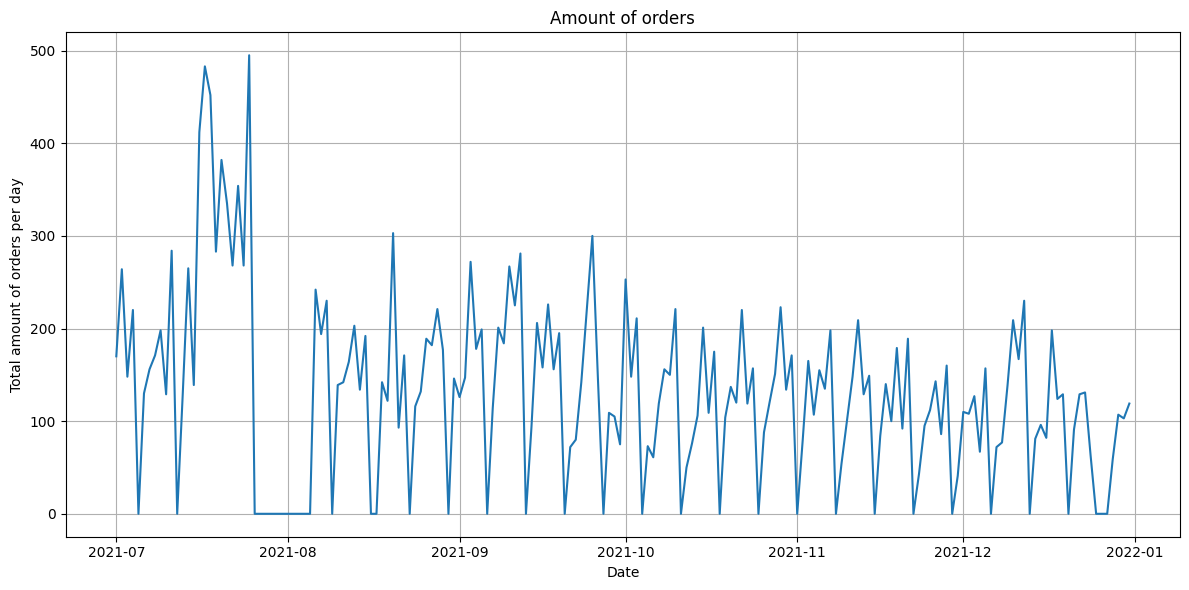

In [15]:
# Group by orders and calculate the total amount of orders for each date
orders_df = combined_df.groupby(combined_df.index).apply(
    lambda x: x['amount_of_orders'].sum()
)

date_range = pd.date_range(start='2021-07-01', end='2021-12-31')
orders_df = orders_df.reindex(date_range, fill_value=0)

create_plot(orders_df.index, orders_df, "Total amount of orders per day", "Date", "Total amount of orders per day", "Amount of orders")

As we can see there is a substantial increase of amount of orders after 2021-07-16, this is not an outlier since this week it was Kermis in Tilburg which is an event that attracts a lot of customers. Additionally, every 7th day the total amount of orders per day decreases to 0 as this is the non-working-day of Den Besterd.

In the codeblock below we analyse the revenue as well, which is the price multiplied by the amount of orders per food item. 

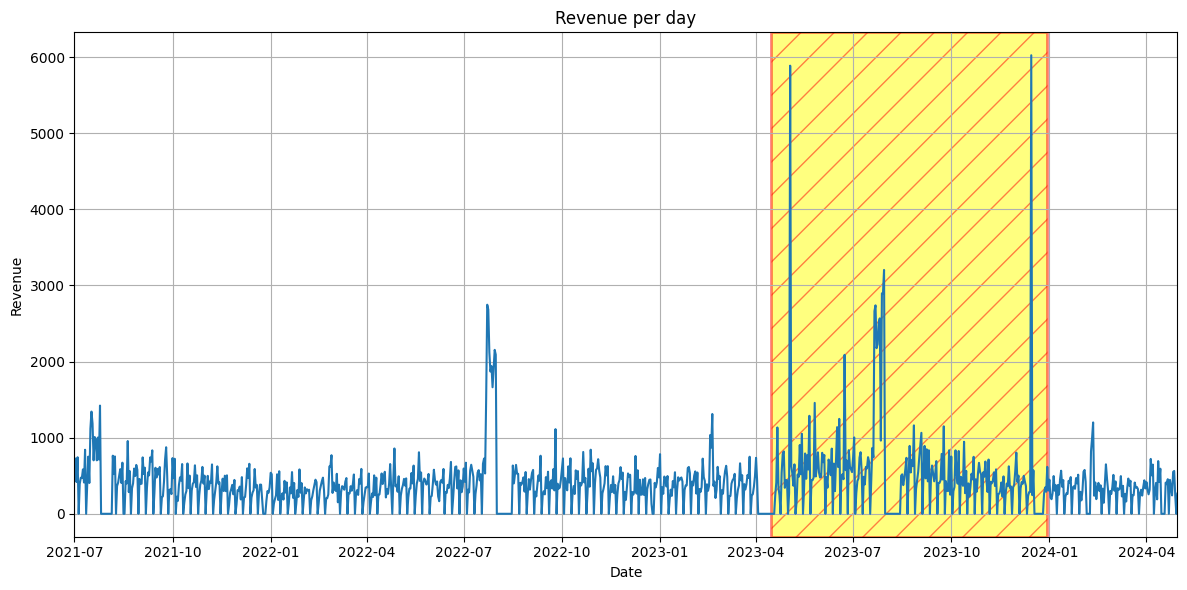

In [16]:
# Group by date and calculate the total revenue for each date
revenue_df = combined_df.groupby(combined_df.index).apply(
    lambda x: (x['price'] * x['amount_of_orders']).sum()
)

date_range = pd.date_range(start=start_date, end=end_date)
revenue_df = revenue_df.reindex(date_range, fill_value=0)


create_plot(revenue_df.index, revenue_df, "Revenue per day", "Date", "Revenue", "Revenue per day", xlim=(start_date, end_date), highlights=('2023-04-15','2023-12-30'))

The yellow highlighted zone in the line plot indicates the region with significant outliers. As we can see there are two points that stand out prominently. In the code cell below, we visualize what those two points represent.

In [17]:
revenue_df.sort_values(ascending=False)[:5]

2023-12-15    6024.25
2023-05-03    5887.10
2023-07-30    3203.50
2023-07-28    2896.90
2023-07-29    2893.25
dtype: float64

In [18]:
combined_df.loc['2023-12-15']

,food_item,price,amount_of_orders
date,,,
2023-12-15,frikandel speciaal,3.25,151
2023-12-15,friet,2.20,139
2023-12-15,frikandel,1.95,126
2023-12-15,friet speciaal,3.70,89
2023-12-15,kroket,1.95,85
...,...,...,...
2023-12-15,sorbet aardbeien,4.00,1
2023-12-15,sorbet kersen,4.00,1
2023-12-15,spa rood,2.50,1


I have done an analysis of the two points, which are 2023-12-15 and 2023-05-03. December 15th 2023 represents "Koningsrijkdag". It was not evident what special day April 3rd 2023 was. 

In [19]:
combined_df = combined_df.drop(index=pd.to_datetime(['2023-12-15','2023-05-03']))

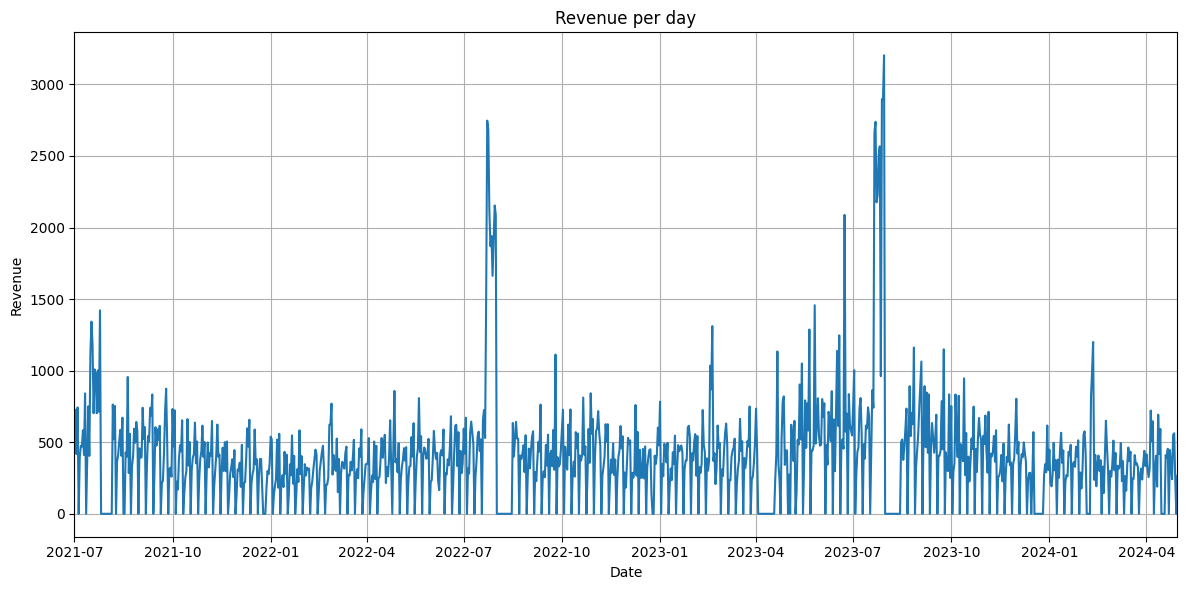

In [20]:
revenue_df = combined_df.groupby(combined_df.index).apply(
    lambda x: (x['price'] * x['amount_of_orders']).sum()
)

date_range = pd.date_range(start=start_date, end=end_date)
revenue_df = revenue_df.reindex(date_range, fill_value=0)

create_plot(revenue_df.index, revenue_df, "Revenue per day", "Date", "Revenue", "Revenue per day", xlim=(start_date, end_date))

In [21]:
total_orders = combined_df.groupby('food_item')['amount_of_orders'].sum()
top_10_items = total_orders.nlargest(10).index
top_10_items

Index(['frikandel speciaal', 'friet', 'frikandel', 'friet speciaal', 'kroket',
       'friet mayonaise', 'friet satésaus', 'kaassouflé', 'friet stoofvlees',
       'mexicano'],
      dtype='object', name='food_item')

In [22]:
monthly_orders_df = combined_df.groupby([pd.Grouper(freq='ME'), 'food_item']).sum().reset_index()
monthly_orders_df = monthly_orders_df.drop('price', axis=1)
monthly_orders_df

,date,food_item,amount_of_orders
0,2021-07-31,3d beker,26
1,2021-07-31,alaska fish burger,5
2,2021-07-31,appelsap,14
3,2021-07-31,asianbox chickenmixed,5
4,2021-07-31,asianbox chicken chunks,1
...,...,...,...
5136,2024-04-30,sundae caramel,8
5137,2024-04-30,sundae stroopwafel topper,5
5138,2024-04-30,variastick,9
5139,2024-04-30,viandel,65


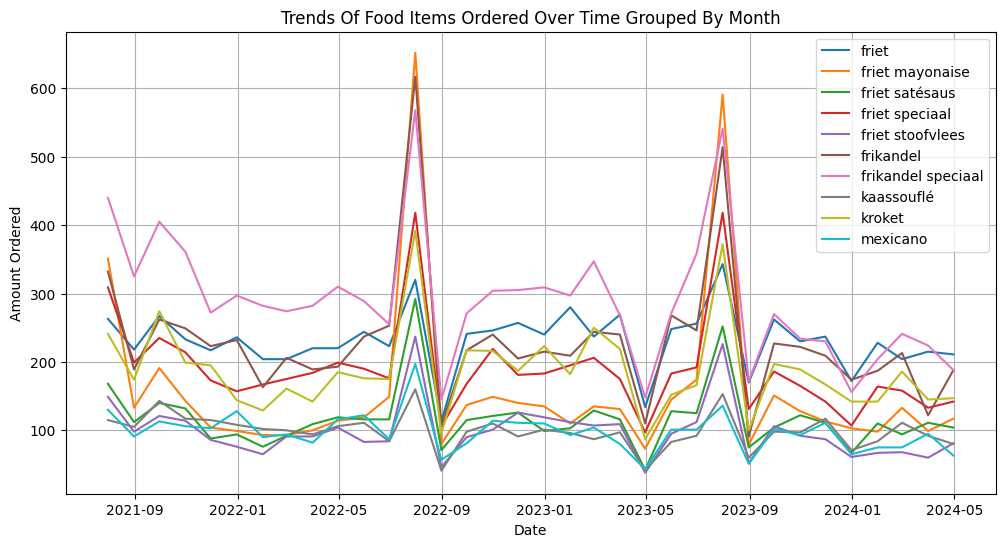

In [23]:
top_10_filtered_df = monthly_orders_df[monthly_orders_df['food_item'].isin(top_10_items)]

# Pivot the DataFrame
top_10_pivot_df = top_10_filtered_df.pivot_table(index='date', columns='food_item', values='amount_of_orders', aggfunc='sum')

plt.figure(figsize=(12, 6))

for column in top_10_pivot_df.columns:
    plt.plot(top_10_pivot_df.index, top_10_pivot_df[column], label=column)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Amount Ordered')
plt.title('Trends Of Food Items Ordered Over Time Grouped By Month')
plt.legend()
plt.grid(True)

plt.show()

# Preprocessing

In [24]:
temp = combined_df.pivot_table(index='date', columns='food_item', values='amount_of_orders', aggfunc='sum').fillna(0)
temp

food_item,3d beker,alaska fish burger,appelsap,asianbox chickenmixed,asianbox chicken chunks,asianbox chicken wings,asianbox chickenstrip,bacon bite burger,bami oriental,bamihap,...,varkenssates met satesaus,vegetarische gyoza,viandel,vietnamese loempia,visstick,vleesboutje,witte wijn ( flesje ),wortelstamp,zubr,zuurkool
date,,,,,,,,,,,,,,,,,,,,,
2021-07-01,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-07-02,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,7.0,...,0.0,0.0,13.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0
2021-07-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,5.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-07-04,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,3.0,...,0.0,0.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-07-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-04-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-04-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,6.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
scaler = MinMaxScaler()
normalized_df = pd.DataFrame(scaler.fit_transform(temp),
                             index=temp.index,
                             columns=temp.columns)

In [26]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length].values
        y = data.iloc[i + seq_length].values
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 4  # Example sequence length of 4 weeks
X, y = create_sequences(normalized_df, SEQ_LENGTH)

In [27]:
print(X.shape, y.shape)

(829, 4, 271) (829, 271)


In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelling



In [29]:
from keras.src.layers import LSTM, Dense
from keras import Sequential, Input

model = Sequential()
model.add(Input(shape=(SEQ_LENGTH, X.shape[2])))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(y_train.shape[1]))  # Predicting 'orders'

In [30]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [31]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200)

Epoch 1/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0146 - val_loss: 0.0126
Epoch 2/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0111 - val_loss: 0.0113
Epoch 3/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0098 - val_loss: 0.0112
Epoch 4/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0103 - val_loss: 0.0113
Epoch 5/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0098 - val_loss: 0.0112
Epoch 6/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0097 - val_loss: 0.0113
Epoch 7/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0096 - val_loss: 0.0111
Epoch 8/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0095 - val_loss: 0.0111
Epoch 9/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0096 - val_loss: 0.0112
Epoch 10/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0092 - val_loss: 0.0110
Epoch 11/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0092 - val_loss: 0.0110
Epoch 12/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.

In [32]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 4, 50)          │        64,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 271)            │         7,046 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 278,765 (1.06 MB)

 Trainable params: 92,921 (362.97 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 185,844 (725.96 KB)

In [33]:
# Get the last sequence from the test set
last_sequence = X_test[-1].reshape((1, SEQ_LENGTH, X_train.shape[2]))

# Predict the next month
predicted_orders = model.predict(last_sequence).flatten()

# Create a DataFrame for the predictions
predicted_df = pd.DataFrame(data=[predicted_orders], columns=normalized_df.columns)

# Inverse transform to get actual values
predicted_df = pd.DataFrame(scaler.inverse_transform(predicted_df), columns=normalized_df.columns)

# Get the top 20 items
top_40_items = predicted_df.T.sort_values(by=0, ascending=False).head(40)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


In [34]:
print("Top 40 Trending Items:")
print(top_40_items)

Top 40 Trending Items:
                               0
food_item                       
friet                   5.763889
frikandel speciaal      5.512714
friet speciaal          4.545106
frikandel               3.463270
kroket                  2.721255
friet mayonaise         2.455809
friet satésaus          2.449825
friet stoofvlees        2.386159
bamihap                 2.158058
viandel                 1.963299
kaassouflé              1.945662
mexicano                1.895241
kinder ijs              1.644125
friet oorlog            1.457836
kipnuggets              1.442807
cheese burger           1.383984
goulashkroket           1.224022
bami oriental           1.014568
picanto                 1.003547
familiezak friet klein  0.960477
classic burger          0.881206
kipkorn                 0.823913
rode wijn               0.654283
bereklauw               0.650095
chicken burger          0.642298
coca cola zero          0.604650
coca cola               0.573248
menu haasbiefstuk   